<a href="https://colab.research.google.com/github/TAKE-JP-17/Pytorch/blob/main/pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Some plot settings
plt.close('all')
plt.rcParams['font.family']= 'serif'
plt.rcParams['font.serif']= 'Times New Roman'
plt.rcParams['font.size']= 10
plt.rcParams['figure.dpi']= 100

In [2]:
# Define the neural network model
# create_model() - This function defines and returns a dictionary representing a NN model. within the dictionary the keys are the layer names and the values are the corresponding Dense layers.

def create_model():
  model = {
      'dense1': tf.keras.layers.Dense(50, activation='tanh'),
      'dense2': tf.keras.layers.Dense(50, activation='tanh'),
      'dense3': tf.keras.layers.Dense(50, activation='tanh'),
      'output_layer': tf.keras.layers.Dense(1)
  }
  return model

# call_model - This function defines the forward pass of the NN. It takes as input a dictionary model (created by create_model()) and an input tensor x.

def call_model(model,x):
  x = model['dense1'](x)
  x = model['dense2'](x)
  x = model['dense3'](x)
  x = model['output_layer'](x)
  return x

# model = create_model()
# print(model)


In [3]:
# Define the differential equation using tf.GradientTape
def pde(x, model):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y_pred = call_model(model, x)
    y_x = tape.gradient(y_pred, x)
  y_xx = tape.gradient(y_x, x)
  del tape
  return y_xx + np.pi**2 * tf.sin(np.pi * x)

In [4]:
# Define the loss function
def loss(model, x, x_bc, y_bc):
  res = pde(x, model)
  # Compute the mean squared error of the boundary conditions
  loss_pde = tf.reduce_mean(tf.square(res))
  y_bc_pred = call_model(model, x_bc)
  # Compute the mean squared error of the boundary conditions
  loss_bc = tf.reduce_mean(tf.square(y_bc - y_bc_pred))
  return loss_pde + loss_bc

In [5]:
# Define the training step
def train_step(model, x, x_bc, y_bc, optimizer):
  with tf.GradientTape() as tape:
    loss_value = loss(model, x, x_bc, y_bc)
  grads = tape.gradient(loss_value, [layer.trainable_variables for layer in model.values()])
  # Flatten the list of trainable variables
  grads = [var for sublist in grads for var in sublist]
  variables = [var for layer in model.values() for var in layer.trainable_variables]
  optimizer.apply_gradients(zip(grads, variables))
  return loss_value

In [6]:
# Setting up the problem

# Generate training data
x_train = np.linspace(-1, 1, 100).reshape(-1, 1)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)

# Boundary data
x_bc = np.array([[-1.0],[1.0]], dtype=np.float32)
y_bc = np.array([[0.0],[0.0]], dtype=np.float32)
x_bc = tf.convert_to_tensor(x_bc, dtype=tf.float32)
y_bc = tf.convert_to_tensor(y_bc, dtype=tf.float32)

# Define the PINN model
model = create_model()

# Define the optimizer with a learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Train the model
epochs = 2000
for epoch in range(epochs):
  loss_value = train_step(model, x_train, x_bc, y_bc, optimizer)
  if epoch % 1000 == 0:
    print(f"Epoch {epoch}: Loss = {loss_value.numpy()}")

Epoch 0: Loss = 47.78607940673828
Epoch 1000: Loss = 0.0011894560884684324


In [7]:
# Predict the solution
x_test = np.linspace(-1, 1, 1000).reshape(-1, 1)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = call_model(model, x_test).numpy()

# Analytical solution
y_true = np.sin(np.pi * x_test)

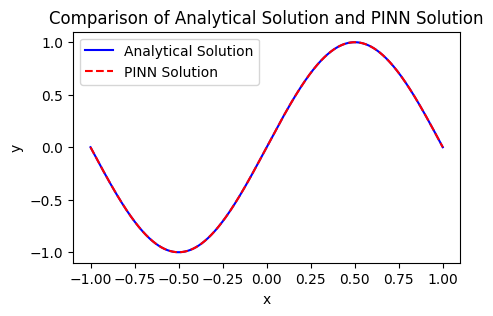

In [8]:
# Plot the results
plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-',label='Analytical Solution')
plt.plot(x_test, y_pred, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical Solution and PINN Solution')
plt.show()